# Time Series Frequency Modelling with Fourier Transform and TimeGPT-1
Real-world time series often consist of patterns that occur **periodically** and at **multiple scales**. This is because Nature is inherently rhythmic, and so are human behaviors.

For example:
* We wake up **every day** at a certain time
* We celebrate **our birthday** after 365 days
* We relax **every sunday**.

For this reason, as we are dealing with time series with clear and evident patterns, it usually makes sense to treat the different **time scales** and analyze them one at a time. This allows us to analyze the problems at different levels and uncovers a deeper understanding of the phenomenon that the time series represents. 

A very famous mathematical transformation that allows us to decompose a multi-level pattern time series is known as the **Fourier Transform** (FT). The FT transforms a time-domain signal into its frequency components, revealing the underlying periodicities that drive the observed patterns. This method is very well known and frequently used in signal processing engineering.

In this blog post, we will combine the intuition of the Fourier Transform with the power of [TimeGPT-1](https://www.nixtla.io/docs), a state-of-the-art foundation model for time series forecasting developed by Nixtla, capable of modelling time series with a very high degree of accuracy. TimeGPT-1 will be thus adopted at different scales and will be used to model all the sub-patterns of our time series.

## About the Fourier Transform

### Fourier Transform Theory

[Fourier Transform](https://www.sciencedirect.com/topics/engineering/fourier-transform) that allows to explore the time series in the **frequency domain**. Let me explain this further.

You might be familiar with the equation of a **sine wave**:
![Alt text](images/sinewave.svg)

In this equation the frequency, f, is a scalar value. For example, if
* f = 1 the wave completes one full cycle per time unit.
* f = 2 the wave completes two full cycles per time unit, and so on.

A real world time series might be composed of multiple **sine waves**. For example, a time series composed of m sine waves is represented by the equation: 

![Alt text](images/sum_of_sines.svg)

The Fourier Transform takes this complex time series, made up of many overlapping waves, and breaks it down into a set of sine and cosine components, each with its own frequency and amplitude.

### Fourier Transform Example

Let's consider the time series with equation `y(t) = 1 * sin(1*t) + 2 * sin(5*t)`. This means that this time series is the sum of:
* A sine wave with frequency f = 1 and amplitude A = 1
* A sine wave with frequency f = 5 and amplitude A = 2

Let's represent that.

Text(0, 0.5, 'Amplitude (y)')

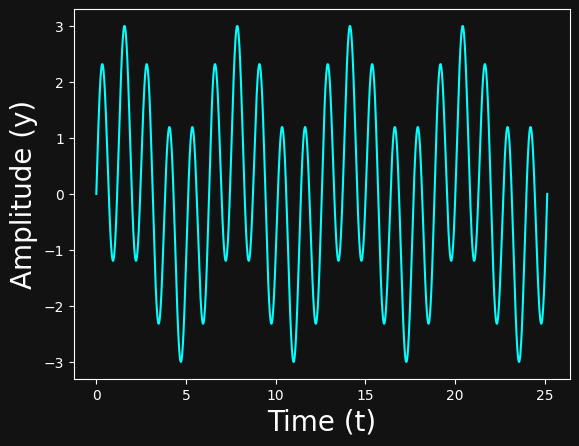

In [23]:
import numpy as np 
import matplotlib.pyplot as plt
t = np.linspace(0,8*np.pi,2000)
y = np.sin(t) + 2*np.sin(5*t)
plt.plot(t,y, color ='cyan')
plt.xlabel('Time (t)', fontsize = 20)
plt.ylabel('Amplitude (y)', fontsize = 20)

In [24]:
# Export Chart 1: Simple sine wave
import pandas as pd
chart_1_data = pd.DataFrame({
    't': t,
    'y': y
})
chart_1_data.to_csv("../../../posts/images/frequency_ts_modelling/chart-1.csv", index=False)

![pic](images/example_ts.svg)

Now let's run the Fourier Transform of this time series. Running the Fourier Transform in Python can be easily done within the `numpy` module. Let's run it and comment the output:

In [25]:
import numpy as np 
t = np.linspace(0,8*np.pi,2000)
y = np.sin(t) + 2*np.sin(5*t)
y_fft = np.fft.fft(y)
print(y_fft[0:5])

[2.15105711e-14+0.00000000e+00j 5.75978513e-04-3.66679008e-01j
 2.72675550e-03-8.67950376e-01j 9.50889536e-03-2.01783533e+00j
 6.28414709e+00-1.00013991e+03j]


As we can see, the output is a **complex number**. This is because every sine wave has a frequency but it also has a **phase**. Now the big question:

***"Can we retrieve the two sine waves, with amplitudes 1 and 2 and frequency 1 and 5?"***

Let's give a look:

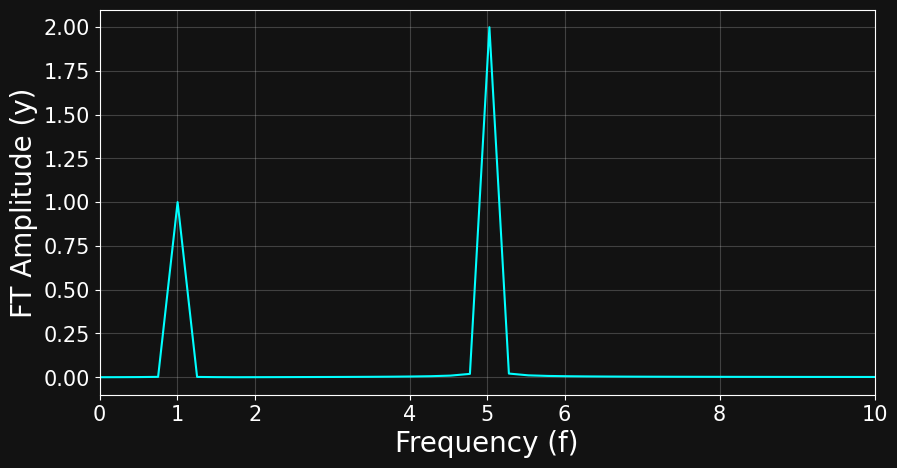

In [26]:
import numpy as np 
from plotter import set_dark_mode
t = np.linspace(0,8*np.pi,2000)
y = np.sin(t) + 2*np.sin(5*t)
y_fft = np.fft.fft(y)
f = t*20 #Numpy implementation constant
y_amp = 2*np.abs(y_fft)/2000 #Amplitude definition
plot_lim = 100
set_dark_mode()
plt.figure(figsize = (10,5))
plt.plot(f[:plot_lim],y_amp[:plot_lim], color ='cyan')
plt.xlabel('Frequency (f)',fontsize = 20)
plt.ylabel('FT Amplitude (y)',fontsize = 20)
plt.xlim(0,10)
plt.xticks([0,1,2,4,5,6,8,10],fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid(alpha=0.2)
plt.savefig('images/fft_example.svg')


In [27]:
# Export Chart 2: FFT amplitude spectrum
chart_2_data = pd.DataFrame({
    'frequency': f[:plot_lim],
    'amplitude': y_amp[:plot_lim]
})
chart_2_data.to_csv("../../../posts/images/frequency_ts_modelling/chart-2.csv", index=False)

This plot tells us that, indeed, the Fourier Transform is able to retrieve that the input time series is composed by the sum of two time series:
* A sine wave with amplitude = 1 and frequency = 1 (first peak)
* A sine wave with amplitude = 2 and frequency = 5 (second peak)

Notice that we can run the **inverse** Fourier Transform on the frequency time series and reconstruct exactly the same input time series:


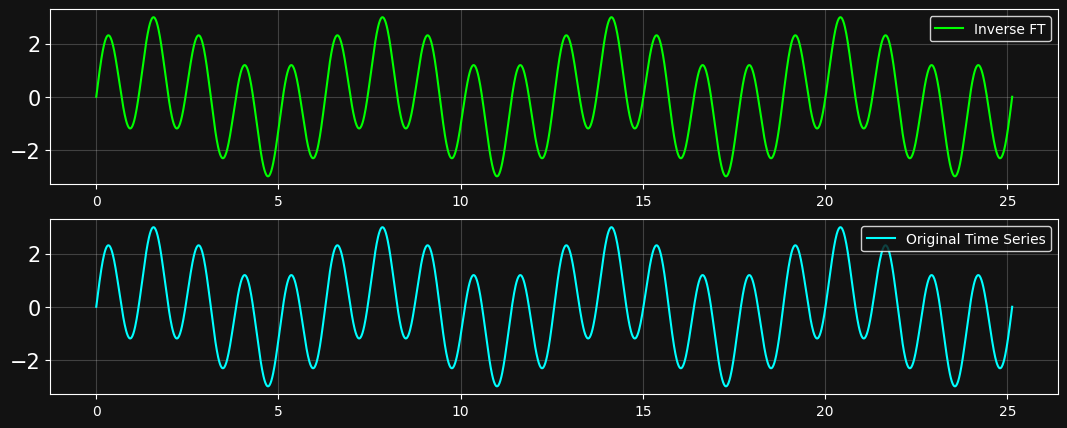

In [28]:
import numpy as np 
t = np.linspace(0,8*np.pi,2000)
y = np.sin(t) + 2*np.sin(5*t)
y_fft = np.fft.fft(y)
y_iff_fft = np.fft.ifft(y_fft).real #Inverse Fourier Transform!
plt.figure(figsize = (13,5))
plt.subplot(2,1,1)
plt.plot(t, y_iff_fft, color ='lime', label = 'Inverse FT')
plt.yticks(fontsize = 15)
plt.grid(alpha=0.2)
plt.legend()
plt.subplot(2,1,2)
plt.plot(t, y, color ='cyan', label = 'Original Time Series')
plt.yticks(fontsize = 15)
plt.legend()
plt.grid(alpha=0.2)
plt.savefig('images/ifft_rec.svg')

In [29]:
# Export Chart 3: Inverse FFT comparison
chart_3_data = pd.DataFrame({
    't': t,
    'inverse_fft': y_iff_fft,
    'original': y
})
chart_3_data.to_csv("../../../posts/images/frequency_ts_modelling/chart-3.csv", index=False)

Pretty amazing right? Now let's see how we can use this tool.

### Fourier Transform Filtering

Ok, so now let's make things really complicated. Let's build a signal with: 
* 4 low frequency sine wave components
* 4 middle frequency sine wave components
* 4 high frequency sine wave components



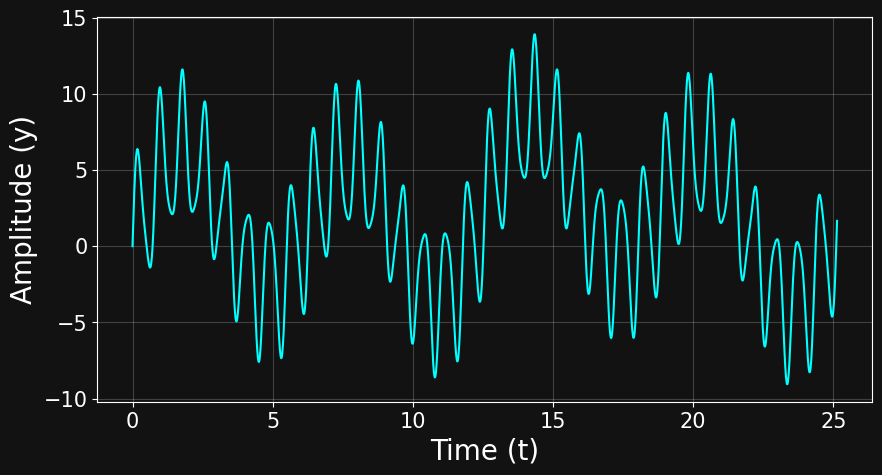

In [30]:
from plotter import set_dark_mode
low_frequencies = [0.1,0.5,1]
high_frequencies = [7,8,15]
frequencies = low_frequencies + high_frequencies
t = np.linspace(0,8*np.pi,2000)
y = np.zeros_like(t)
for f in frequencies:
    rand_amp = np.random.choice(np.linspace(0,5,2000))
    y += rand_amp*np.sin(t*f)
plt.figure(figsize = (10,5))
set_dark_mode()
plt.plot(t,y, color ='cyan')
plt.xlabel('Time (t)',fontsize = 20)
plt.ylabel('Amplitude (y)',fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid(alpha=0.2)
plt.savefig('images/complex_timeseries.svg')


In [31]:
# Export Chart 4: Complex multi-frequency time series
chart_4_data = pd.DataFrame({
    't': t,
    'y': y
})
chart_4_data.to_csv("../../../posts/images/frequency_ts_modelling/chart-4.csv", index=False)

Now, at this point, identifying the specific component is not trivial nor necessary. Nonetheless, we can run the Fourier Transform and split it into three non overlapping parts: 
* The low frequency area, setting everything above a certain threshold to 0.
* The middle frequency area, setting everything above and below two given thresholds to 0.
* The high frequency area, setting everything below a given threshold to 0.




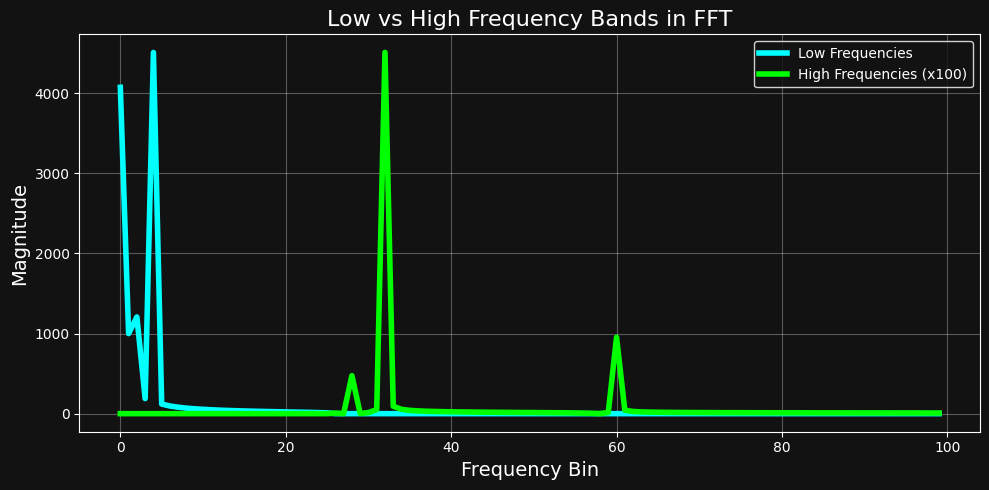

In [32]:
from numpy.fft import fft, ifft, fftfreq
import numpy as np
import matplotlib.pyplot as plt

# Compute FFT
y_fft = fft(y)
freqs = fftfreq(len(t), d=(t[1] - t[0]))

# Helper function to filter by frequency range
def filter_freq_component(y_fft, freqs, low, high):
    mask = (np.abs(freqs) >= low) & (np.abs(freqs) <= high)
    filtered_fft = np.zeros_like(y_fft, dtype=complex)
    filtered_fft[mask] = y_fft[mask]
    return filtered_fft

# Define frequency bands
low_band = (0.0, 1.0)
high_band = (1.0, 20)

# Filter each band
low_fft = filter_freq_component(y_fft, freqs, *low_band)
high_fft = filter_freq_component(y_fft, freqs, *high_band)

# Plot FFT magnitudes
plt.figure(figsize=(10, 5))
plt.plot(np.abs(low_fft)[0:100], label="Low Frequencies", linewidth=4,color='cyan')
plt.plot(np.abs(high_fft)[0:100]*1, label="High Frequencies (x100)", linewidth=4,color='lime')
plt.xlabel("Frequency Bin", fontsize=14)
plt.ylabel("Magnitude", fontsize=14)
plt.title("Low vs High Frequency Bands in FFT", fontsize=16)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('images/fourier_filtering.svg')
plt.show()




In [33]:
# Export Chart 5: Fourier filtering - frequency bands
chart_5_data = pd.DataFrame({
    'frequency_bin': range(100),
    'low_freq_magnitude': np.abs(low_fft)[0:100],
    'high_freq_magnitude': np.abs(high_fft)[0:100]
})
chart_5_data.to_csv("../../../posts/images/frequency_ts_modelling/chart-5.csv", index=False)

As we can see we retrieve the three peaks for the low frequency and the three peaks for the high frequency. Actually, we can do even more: for each one of these parts we can run the **inverse** Fourier Transform.

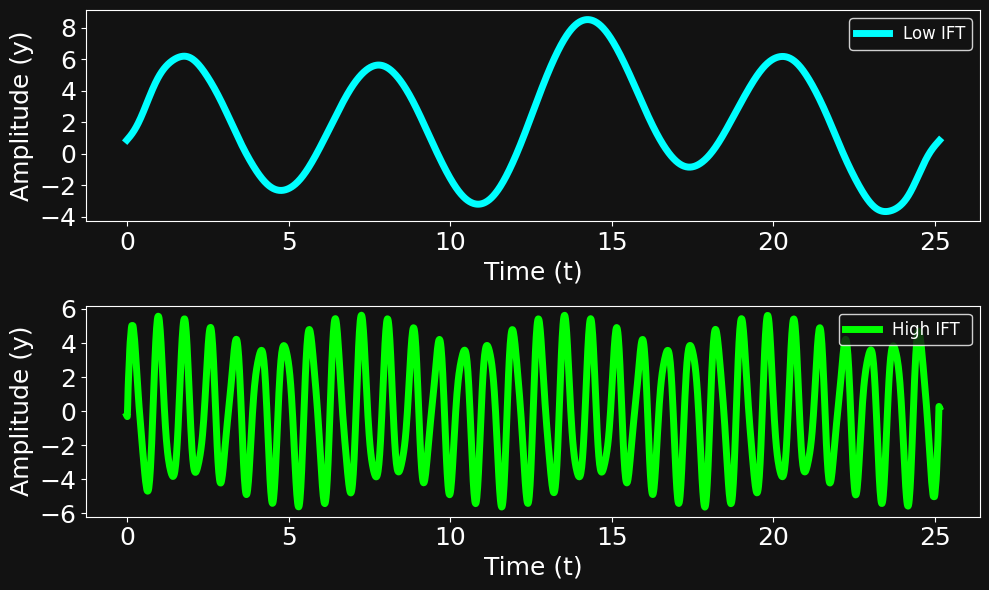

In [35]:
low_ifft = np.fft.ifft(low_fft).real
high_ifft = np.fft.ifft(high_fft).real
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(t, low_ifft, lw = 5, color = 'cyan', label = 'Low IFT')
plt.xlabel('Time (t)',fontsize= 18)
plt.ylabel('Amplitude (y)',fontsize= 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.legend(fontsize = 12)
plt.subplot(2,1,2)
plt.plot(t, high_ifft, lw = 5, color = 'lime', label = 'High IFT ')
plt.xlabel('Time (t)',fontsize= 18)
plt.ylabel('Amplitude (y)',fontsize= 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.tight_layout()
plt.legend(fontsize = 12)
plt.savefig('images/fourier_filtering_ifft.svg')

In [36]:
# Export Chart 6: Filtered inverse FFT components
chart_6_data = pd.DataFrame({
    't': t,
    'low_ifft': low_ifft,
    'high_ifft': high_ifft
})
chart_6_data.to_csv("../../../posts/images/frequency_ts_modelling/chart-6.csv", index=False)

This is very important as these two sub-timeseries might indicate two different phenomena in our system. For example, in a financial time series, one might represent the long scale variation of a financial quantity, and one might represent the short scale (e.g. impulse decisions) of the same financial quantity. 

## Modelling Stage

To summarize: we have a method that is able to identify multiple sources of the same time series based on their difference in terms of **frequency**. In other words, given a single time series, our method is able to split it in multiple time series that, summed together, will return the original one. This is helpful because it can precisely identify the different phenomena of our system, so that we are able to study them individually.

As we have the different sources time series, now we can worry about **modelling** them. By "modelling" I mean building mathematical or machine learning models that can learn the behavior of each individual component over time, forecast its future evolution, and help us understand its contribution to the overall dynamics of the original time series.

The model we are going to use in this Blog post is the [Time GPT-1](https://www.nixtla.io/docs) one developed by the [Nixtla](https://www.nixtla.io/) team. This model is a large, pre-trained foundation model specifically designed for time series forecasting.

Without furhter ado, let's start with the modelling. 

### Nixtla API and Implementation

The first thing we will need is to define your API key. You can get one from [Nixtla's platform](https://dashboard.nixtla.io/). Once you have your API key, store it somewhere and paste it down here using the api_key variable. 

In [40]:
from nixtla import NixtlaClient
from dotenv import load_dotenv

load_dotenv()
nixtla_client = NixtlaClient()

Now that we have the API key we can run the `.forecast` feature to predict the next step **for each one of the time series (the low frequency time series and the high frequency one)**. 

In [41]:
import pandas as pd 
timeseries_collection = [low_ifft, high_ifft]
df_s = []
forecast_dfs = []
pred_len = 5
quartile = 90
for timeseries in timeseries_collection:
    timestamps = pd.date_range(start='2020-01-01', periods=len(timeseries), freq='H')
    df = pd.DataFrame({
        'ds': timestamps,
        'y': timeseries,
        'unique_id': 0 
    })
    
    test = df[-pred_len:]            
    input_seq = df[-pred_len-2000:-pred_len]
    fcst_df = nixtla_client.forecast(
        df=input_seq,
        h=pred_len,
        level=[90],
        finetune_steps=5,
        finetune_loss='mae',
        model='timegpt-1',
        time_col='ds',
        target_col='y'
    )
    forecast_dfs.append(fcst_df)
    df_s.append(df)

/var/folders/5w/fg65_rp17lz39z89p0nkv8ch0000gn/T/ipykernel_45053/578422716.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start='2020-01-01', periods=len(timeseries), freq='H')
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: h
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
/var/folders/5w/fg65_rp17lz39z89p0nkv8ch0000gn/T/ipykernel_45053/578422716.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start='2020-01-01', periods=len(timeseries), freq='H')
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: h
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


The code above uses `nixtla_client.forecast()` on each one of the two time series. This means that we are not only able to forecast the full timeseries, but we are also able to individually forecast the low frequency component and the high frequency one. As we can see from the picture below, the results are pretty good for the high frequency one:

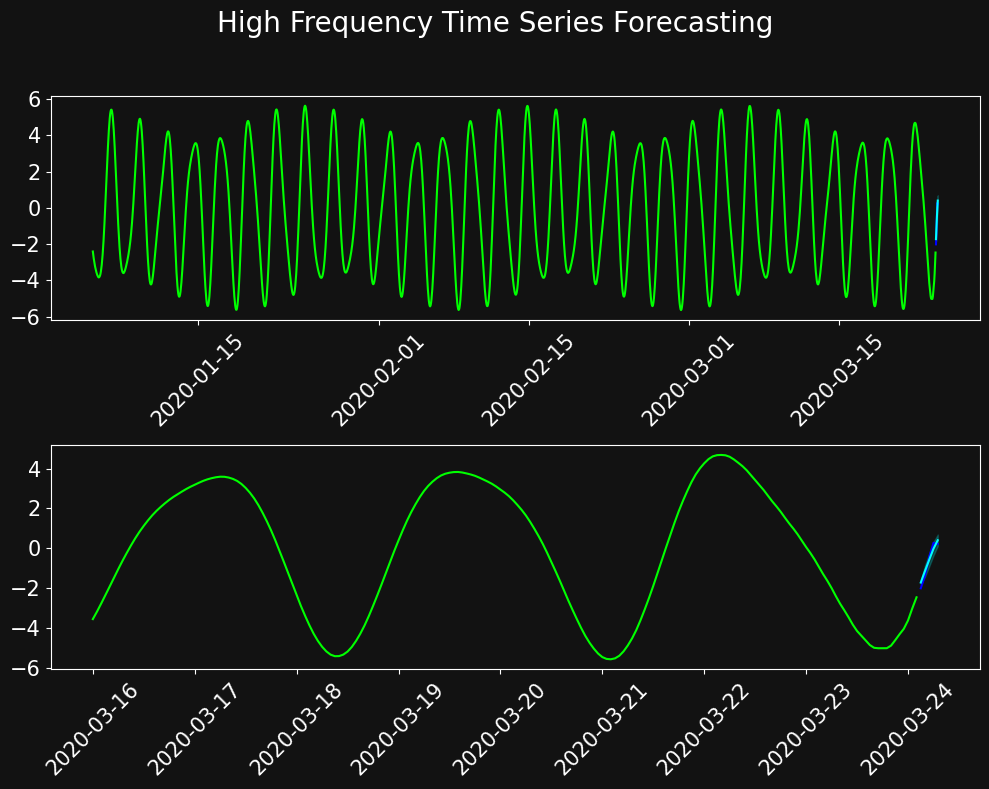

In [42]:
test = df_s[1][-pred_len:]            
input_seq = df_s[1][-pred_len-2000:-pred_len]
fcst_df = forecast_dfs[1]
plt.figure(figsize = (10,8))
plt.suptitle('High Frequency Time Series Forecasting', fontsize = 20)
plt.subplot(2,1,1)
plt.plot(np.array(test['ds']),np.array(test['y']), color = 'blue')
plt.plot(np.array(input_seq['ds'][100:]),np.array(input_seq['y'][100:]), color = 'lime')
plt.plot(np.array(fcst_df['ds']),np.array(fcst_df['TimeGPT']), color = 'cyan')
plt.fill_between(np.array(fcst_df['ds']),np.array(fcst_df['TimeGPT-lo-90']), np.array(fcst_df['TimeGPT-hi-90']), color ='cyan', alpha = 0.2)
plt.xticks(fontsize = 15,rotation = 45)
plt.yticks(fontsize = 15)
plt.subplot(2,1,2)
plt.plot(np.array(test['ds']),np.array(test['y']), color = 'blue')
plt.plot(np.array(input_seq['ds'][1800:]),np.array(input_seq['y'][1800:]), color = 'lime')
plt.plot(np.array(fcst_df['ds']),np.array(fcst_df['TimeGPT']), color = 'cyan')
plt.fill_between(np.array(fcst_df['ds']),np.array(fcst_df['TimeGPT-lo-90']), np.array(fcst_df['TimeGPT-hi-90']), color ='cyan', alpha = 0.2)
plt.xticks(fontsize = 15,rotation = 45)
plt.yticks(fontsize = 15)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('images/high_frequency_ts.svg')

In [43]:
# Export Chart 7: High frequency time series forecast
chart_7_data = pd.DataFrame({
    'ds': list(input_seq['ds']) + list(test['ds']) + list(fcst_df['ds']),
    'actual': list(input_seq['y']) + list(test['y']) + [np.nan] * len(fcst_df),
    'forecast': [np.nan] * len(input_seq) + [np.nan] * len(test) + list(fcst_df['TimeGPT']),
    'lo_90': [np.nan] * len(input_seq) + [np.nan] * len(test) + list(fcst_df['TimeGPT-lo-90']),
    'hi_90': [np.nan] * len(input_seq) + [np.nan] * len(test) + list(fcst_df['TimeGPT-hi-90']),
    'type': ['historical'] * len(input_seq) + ['historical'] * len(test) + ['forecast'] * len(fcst_df)
})
chart_7_data.to_csv("../../../posts/images/frequency_ts_modelling/chart-7.csv", index=False)

And the same applies to the low frequency forecasting:

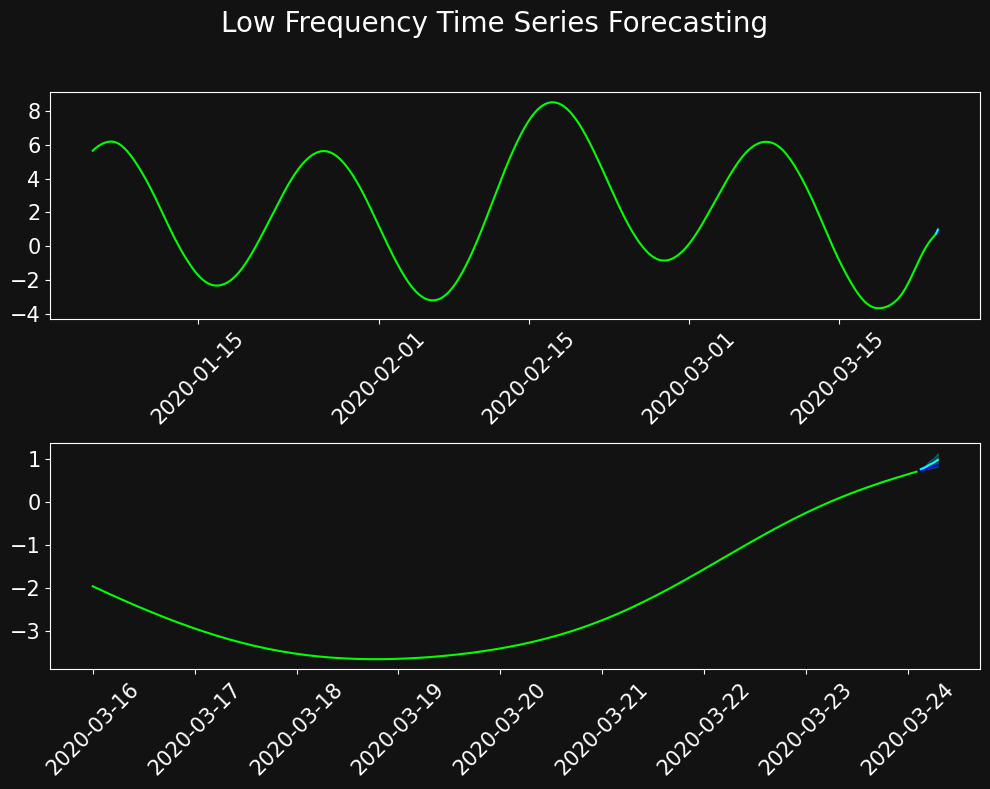

In [44]:
test = df_s[0][-pred_len:]            
input_seq = df_s[0][-pred_len-2000:-pred_len]
fcst_df = forecast_dfs[0] 
plt.figure(figsize = (10,8))
plt.suptitle('Low Frequency Time Series Forecasting', fontsize = 20)
plt.subplot(2,1,1)
plt.plot(np.array(test['ds']),np.array(test['y']), color = 'blue')
plt.plot(np.array(input_seq['ds'][100:]),np.array(input_seq['y'][100:]), color = 'lime')
plt.plot(np.array(fcst_df['ds']),np.array(fcst_df['TimeGPT']), color = 'cyan')
plt.fill_between(np.array(fcst_df['ds']),np.array(fcst_df['TimeGPT-lo-90']), np.array(fcst_df['TimeGPT-hi-90']), color ='cyan', alpha = 0.2)
plt.xticks(fontsize = 15,rotation = 45)
plt.yticks(fontsize = 15)
plt.subplot(2,1,2)
plt.plot(np.array(test['ds']),np.array(test['y']), color = 'blue')
plt.plot(np.array(input_seq['ds'][1800:]),np.array(input_seq['y'][1800:]), color = 'lime')
plt.plot(np.array(fcst_df['ds']),np.array(fcst_df['TimeGPT']), color = 'cyan')
plt.fill_between(np.array(fcst_df['ds']),np.array(fcst_df['TimeGPT-lo-90']), np.array(fcst_df['TimeGPT-hi-90']), color ='cyan', alpha = 0.2)
plt.xticks(fontsize = 15,rotation = 45)
plt.yticks(fontsize = 15)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('images/low_frequency_ts.svg')

In [45]:
# Export Chart 8: Low frequency time series forecast
chart_8_data = pd.DataFrame({
    'ds': list(input_seq['ds']) + list(test['ds']) + list(fcst_df['ds']),
    'actual': list(input_seq['y']) + list(test['y']) + [np.nan] * len(fcst_df),
    'forecast': [np.nan] * len(input_seq) + [np.nan] * len(test) + list(fcst_df['TimeGPT']),
    'lo_90': [np.nan] * len(input_seq) + [np.nan] * len(test) + list(fcst_df['TimeGPT-lo-90']),
    'hi_90': [np.nan] * len(input_seq) + [np.nan] * len(test) + list(fcst_df['TimeGPT-hi-90']),
    'type': ['historical'] * len(input_seq) + ['historical'] * len(test) + ['forecast'] * len(fcst_df)
})
chart_8_data.to_csv("../../../posts/images/frequency_ts_modelling/chart-8.csv", index=False)

## Putting everthing together

